# Quickstart - Run TiRex on GiftEval

This notebook shows how to run [TiRex](https://github.com/NX-AI/tirex) on the gift-eval benchmark.

Make sure you download the gift-eval benchmark and set the `GIFT-EVAL` environment variable correctly before running this notebook.


## Setup Instructions

Before proceeding, ensure you have the following:
(Note: You need a Nvidia GPU with [CUDA compute capabality >= 8.0](https://developer.nvidia.com/cuda-gpus))

1. **Optional but suggested: Install conda environment specifed in TiRex Repo**

```bash
git clone github.com/NX-AI/tirex
conda env create --file ./tirex/requirements_py26.yaml
conda activate tirex
```

2. **Install TiRex**

```bash
git clone github.com/NX-AI/tirex  # if not cloned before
cd tirex
pip install .  # install tirex
```

3. **Install additional dependecies needed for GiftEval benchmark**

```bash
pip install gluonts dotenv datasets
```

In [1]:
#
# This is the data.py file as in GiftEval but fixed so that one can run it with numpy >2.0.0
# (Extended/Fixed the frequency alias)
#

import os
import math
from functools import cached_property
from enum import Enum
from pathlib import Path
import sys
from typing import Iterable, Iterator

import datasets
from dotenv import load_dotenv
from gluonts.dataset import DataEntry
from gluonts.dataset.common import ProcessDataEntry
from gluonts.dataset.split import TestData, TrainingDataset, split
from gluonts.itertools import Map
from gluonts.time_feature import norm_freq_str
from gluonts.transform import Transformation
import matplotlib.pyplot as plt
from pandas.tseries.frequencies import to_offset
import pyarrow.compute as pc
from toolz import compose

sys.path.append('../src')
from timesc.quantile_sampling import *
from timesc.generate_synthetic_ts import *

TEST_SPLIT = 0.1
MAX_WINDOW = 20

M4_PRED_LENGTH_MAP = {
    "A": 6,
    "Q": 8,
    "M": 18,
    "W": 13,
    "D": 14,
    "H": 48,
    # new version fix:
    "h": 48,
    "Y": 6,

}

PRED_LENGTH_MAP = {
    "M": 12,
    "W": 8,
    "D": 30,
    "H": 48,
    "T": 48,
    "S": 60,
    # new version fix:
    "h": 48,
    "s": 60,
    "min": 48,
}

TFB_PRED_LENGTH_MAP = {
    "A": 6,
    "H": 48,
    "Q": 8,
    "D": 14,
    "M": 18,
    "W": 13,
    "U": 8,
    "T": 8,
    # new version fix:
    "min": 8,
    "us": 8,
    "Y": 6,
    "h": 48,
}


class Term(Enum):
    SHORT = "short"
    MEDIUM = "medium"
    LONG = "long"

    @property
    def multiplier(self) -> int:
        if self == Term.SHORT:
            return 1
        elif self == Term.MEDIUM:
            return 10
        elif self == Term.LONG:
            return 15


def itemize_start(data_entry: DataEntry) -> DataEntry:
    data_entry["start"] = data_entry["start"].item()
    return data_entry


class MultivariateToUnivariate(Transformation):
    def __init__(self, field):
        self.field = field

    def __call__(
        self, data_it: Iterable[DataEntry], is_train: bool = False
    ) -> Iterator:
        for data_entry in data_it:
            item_id = data_entry["item_id"]
            val_ls = list(data_entry[self.field])
            for id, val in enumerate(val_ls):
                univariate_entry = data_entry.copy()
                univariate_entry[self.field] = val
                univariate_entry["item_id"] = item_id + "_dim" + str(id)
                yield univariate_entry


class Dataset:
    def __init__(
        self,
        name: str,
        term: Term | str = Term.SHORT,
        to_univariate: bool = False,
        storage_env_var: str = "GIFT_EVAL",
    ):
        load_dotenv()
        storage_path = Path('/mnt/data_1/home_tsteam/gift-eval') # os.getenv(storage_env_var))
        self.hf_dataset = datasets.load_from_disk(str(storage_path / name)).with_format(
            "numpy"
        )
        process = ProcessDataEntry(
            self.freq,
            one_dim_target=self.target_dim == 1,
        )

        self.gluonts_dataset = Map(compose(process, itemize_start), self.hf_dataset)
        if to_univariate:
            self.gluonts_dataset = MultivariateToUnivariate("target").apply(
                self.gluonts_dataset
            )

        self.term = Term(term)
        self.name = name

    @cached_property
    def prediction_length(self) -> int:
        freq = norm_freq_str(to_offset(self.freq).name)
        if freq.endswith("E"):
            freq = freq[:-1]
        pred_len = (
            M4_PRED_LENGTH_MAP[freq] if "m4" in self.name else PRED_LENGTH_MAP[freq]
        )
        return self.term.multiplier * pred_len

    @cached_property
    def freq(self) -> str:
        return self.hf_dataset[0]["freq"]

    @cached_property
    def target_dim(self) -> int:
        return (
            target.shape[0]
            if len((target := self.hf_dataset[0]["target"]).shape) > 1
            else 1
        )

    @cached_property
    def past_feat_dynamic_real_dim(self) -> int:
        if "past_feat_dynamic_real" not in self.hf_dataset[0]:
            return 0
        elif (
            len(
                (
                    past_feat_dynamic_real := self.hf_dataset[0][
                        "past_feat_dynamic_real"
                    ]
                ).shape
            )
            > 1
        ):
            return past_feat_dynamic_real.shape[0]
        else:
            return 1

    @cached_property
    def windows(self) -> int:
        if "m4" in self.name:
            return 1
        w = math.ceil(TEST_SPLIT * self._min_series_length / self.prediction_length)
        return min(max(1, w), MAX_WINDOW)

    @cached_property
    def _min_series_length(self) -> int:
        if self.hf_dataset[0]["target"].ndim > 1:
            lengths = pc.list_value_length(
                pc.list_flatten(
                    pc.list_slice(self.hf_dataset.data.column("target"), 0, 1)
                )
            )
        else:
            lengths = pc.list_value_length(self.hf_dataset.data.column("target"))
        return min(lengths.to_numpy())

    @cached_property
    def sum_series_length(self) -> int:
        if self.hf_dataset[0]["target"].ndim > 1:
            lengths = pc.list_value_length(
                pc.list_flatten(self.hf_dataset.data.column("target"))
            )
        else:
            lengths = pc.list_value_length(self.hf_dataset.data.column("target"))
        return sum(lengths.to_numpy())

    @property
    def training_dataset(self) -> TrainingDataset:
        training_dataset, _ = split(
            self.gluonts_dataset, offset=-self.prediction_length * (self.windows + 1)
        )
        return training_dataset

    @property
    def validation_dataset(self) -> TrainingDataset:
        validation_dataset, _ = split(
            self.gluonts_dataset, offset=-self.prediction_length * self.windows
        )
        return validation_dataset

    @property
    def test_data(self) -> TestData:
        _, test_template = split(
            self.gluonts_dataset, offset=-self.prediction_length * self.windows
        )
        test_data = test_template.generate_instances(
            prediction_length=self.prediction_length,
            windows=self.windows,
            distance=self.prediction_length,
        )
        return test_data

/mnt/data_1/home_tsteam/anaconda3/envs/tirex2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/data_1/home_tsteam/anaconda3/envs/tirex2/lib/python3.11/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


## Load Model

In [15]:
import os
import pandas as pd
from tirex import load_model, ForecastModel

model: ForecastModel = load_model("NX-AI/TiRex", device="cuda:3")

/mnt/data_1/home_tsteam/anaconda3/envs/tirex2/lib/python3.11/site-packages/xlstm/blocks/slstm/cell.py:543: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @conditional_decorator(
/mnt/data_1/home_tsteam/anaconda3/envs/tirex2/lib/python3.11/site-packages/xlstm/blocks/slstm/cell.py:568: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @conditional_decorator(


## Load Data

### Synthetic data

In [16]:
X_full_full = make_synthetic_series(256, 2000)

### Gift Eval datasets

In [168]:
import sys

sys.path.append("/mnt/data_1/home_tsteam/malonso/gift-eval/src")

from gift_eval.data import Dataset

import os
from dotenv import load_dotenv
from pathlib import Path

# Load environment variables
load_dotenv()

# Get the GIFT_EVAL path from environment variables
gift_eval_path = "/mnt/data_1/home_tsteam/gift-eval"

if gift_eval_path:
    # Convert to Path object for easier manipulation
    gift_eval_path = Path(gift_eval_path)

    # Get all subdirectories (dataset names) in the GIFT_EVAL path
    dataset_names = []
    for dataset_dir in gift_eval_path.iterdir():
        if dataset_dir.name.startswith("."):
            continue
        if dataset_dir.is_dir():
            freq_dirs = [d for d in dataset_dir.iterdir() if d.is_dir()]
            if freq_dirs:
                for freq_dir in freq_dirs:
                    dataset_names.append(f"{dataset_dir.name}/{freq_dir.name}")
            else:
                dataset_names.append(dataset_dir.name)

    print("Available datasets in GIFT_EVAL:")
    for name in sorted(dataset_names):
        print(f"- {name}")
else:
    print(
        "GIFT_EVAL path not found in environment variables. Please check your .env file."
    )

Available datasets in GIFT_EVAL:
- LOOP_SEATTLE/5T
- LOOP_SEATTLE/D
- LOOP_SEATTLE/H
- M_DENSE/D
- M_DENSE/H
- SZ_TAXI/15T
- SZ_TAXI/H
- artefacts
- bitbrains_fast_storage/5T
- bitbrains_fast_storage/H
- bitbrains_rnd/5T
- bitbrains_rnd/H
- bizitobs_application
- bizitobs_l2c/5T
- bizitobs_l2c/H
- bizitobs_service
- car_parts_with_missing
- cli/conf
- covid_deaths
- dataset/.cache
- dataset/LOOP_SEATTLE
- dataset/M_DENSE
- dataset/SZ_TAXI
- dataset/bitbrains_fast_storage
- dataset/bitbrains_rnd
- dataset/bizitobs_application
- dataset/bizitobs_l2c
- dataset/bizitobs_service
- dataset/car_parts_with_missing
- dataset/covid_deaths
- dataset/electricity
- dataset/ett1
- dataset/ett2
- dataset/hierarchical_sales
- dataset/hospital
- dataset/jena_weather
- dataset/kdd_cup_2018_with_missing
- dataset/m4_daily
- dataset/m4_hourly
- dataset/m4_monthly
- dataset/m4_quarterly
- dataset/m4_weekly
- dataset/m4_yearly
- dataset/restaurant
- dataset/saugeenday
- dataset/solar
- dataset/temperature_r

In [169]:
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt

ds_name = "ett1/H"  # Name of the dataset
to_univariate = True  # Whether to convert the data to univariate
term = "short"  # Term of the dataset

dataset = Dataset(name=ds_name, term=term, to_univariate=to_univariate)
print("Dataset frequency: ", dataset.freq)
print("Prediction length: ", dataset.prediction_length)
print("Number of windows in the rolling evaluation: ", dataset.windows)

Dataset frequency:  H
h
Prediction length:  48
Number of windows in the rolling evaluation:  20


/mnt/data_1/home_tsteam/malonso/gift-eval/src/gift_eval/data.py:138: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = norm_freq_str(to_offset(self.freq).name)


Keys in the validation data:  dict_keys(['item_id', 'start', 'freq', 'target'])
Item id:  item_0_dim0
Start Date:  2016-07-01 00:00
Frequency:  H
Last 10 target values:  [-14.802    -18.619999 -41.527    -39.653    -29.538    -13.999
   5.827     25.989     36.637     41.595   ]


/mnt/data_1/home_tsteam/anaconda3/envs/tirex2/lib/python3.11/site-packages/gluonts/dataset/common.py:263: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.Period(val, freq)


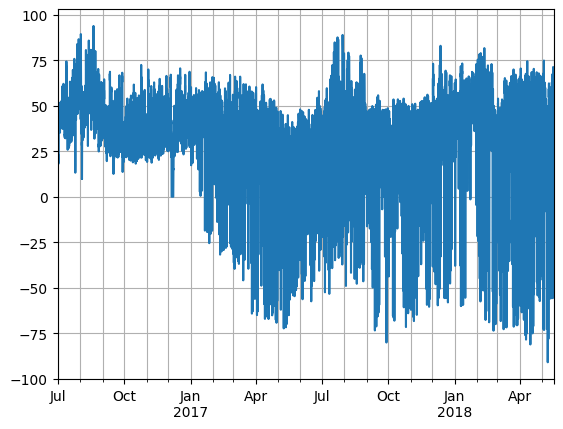

In [170]:
val_data_iter = dataset.validation_dataset

for i, val_data in zip(range(np.random.randint(len(val_data_iter))+1), val_data_iter):
    pass

print("Keys in the validation data: ", val_data.keys())

print("Item id: ", val_data["item_id"])
print("Start Date: ", val_data["start"])
print("Frequency: ", val_data["freq"])
print("Last 10 target values: ", val_data["target"][-10:])

val_series = to_pandas(val_data)
val_series.plot()
plt.grid(which="both")
plt.show()

In [171]:
# val_data_iter = dataset.validation_dataset

# for i, val_data in zip(range(np.random.randint(len(val_data_iter)) + 1), val_data_iter):
#     pass

# val_series = to_pandas(val_data)

# X_full_full = val_series.values[None, :]

### Define prediction task

In [17]:
C = 256 # context length
P = 32 # prediction length
L = C + P

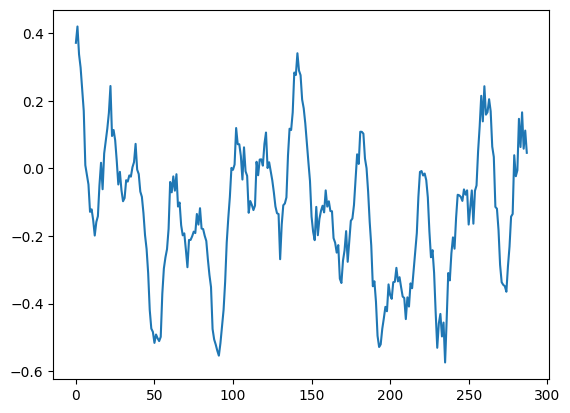

In [18]:
I = np.random.randint(0, len(X_full_full))
X_full = X_full_full #[I : I + 1]
J = np.random.randint(0, len(X_full[0]) - L)
X_full = X_full[:, J : J + L]
plt.plot(X_full[0])
plt.show()

## Quantile-based trajectory sampling

In [19]:
Y, Ymt, full_ymt = quantile_trajectory_sampling(
    X_full,
    C,
    P,
    lambda x: model._forecast_quantiles(x, prediction_length=P)[0]
    .swapaxes(1, 2)
    .numpy(),
    n_trajectories=50,
    frac_quantile_remap=0.00,
)

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [02:31<00:00,  4.74s/it]


### Display prediction error per series

In [20]:
pd.DataFrame(
    [
        np.mean(np.abs(X_full - np.median(Y, axis=1))[:, C:], axis=1),
        np.mean(np.abs(X_full - Ymt[:, :, 4])[:, C:], axis=1),
    ]
).T.style.background_gradient(vmin=0, vmax=0.3, cmap="jet")

,0,1
0,0.093495,0.054551
1,0.048823,0.058178
2,0.055936,0.053930
3,0.082715,0.068170
4,0.051980,0.052476
5,0.047255,0.044569
6,0.146584,0.133895
7,0.136353,0.208633
8,0.159455,0.124064
9,0.084226,0.091245


### ... over horizons

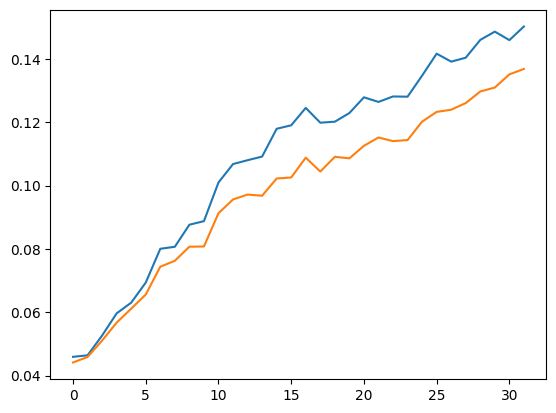

In [21]:
plt.plot(np.mean(np.abs(X_full - np.median(Y, axis=1))[:, C:], axis=0))
plt.plot(np.mean(np.abs(X_full - Ymt[:, :, 4])[:, C:], axis=0))

### ... average

In [22]:
print(np.mean(np.abs(X_full - np.median(Y, axis=1))[:, C:]))
print(np.mean(np.abs(X_full - Ymt[:, :, 4])[:, C:]))
print("--------------")

print(np.mean((np.abs(X_full - np.median(Y, axis=1)) / np.abs(X_full))[:, C:]))
print(np.mean((np.abs(X_full - Ymt[:, :, 4]) / np.abs(X_full))[:, C:]))
print("--------------")

Qs = np.linspace(0.1, 0.9, 9)
diff = X_full - np.quantile(Y, Qs, axis=1)
print(
    np.mean(
        (
            (
                np.maximum(0, diff) * Qs[:, None, None] * 2
                + np.maximum(0, -diff) * (1 - Qs[:, None, None]) * 2
            )
            / np.abs(X_full)
        )[:, :, C:]
    )
)
diff = X_full - np.swapaxes(np.swapaxes(Ymt, 0, 2), 1, 2)
print(
    np.mean(
        (
            (
                np.maximum(0, diff) * Qs[:, None, None] * 2
                + np.maximum(0, -diff) * (1 - Qs[:, None, None]) * 2
            )
            / np.abs(X_full)
        )[:, :, C:]
    )
)

0.10876181950146871
0.09797786
--------------
2.13652583523145
3.3683724
--------------
3.381576349921451
4.1543479167297255


## Plot predictions

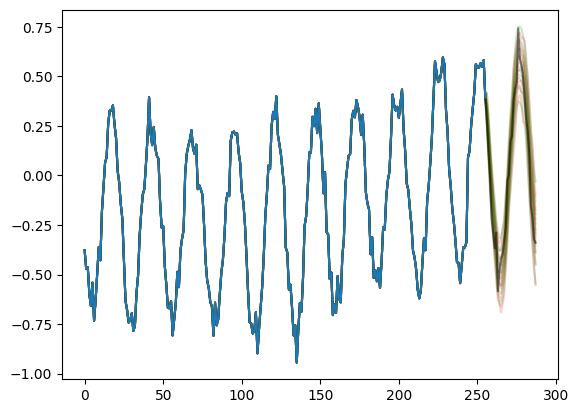

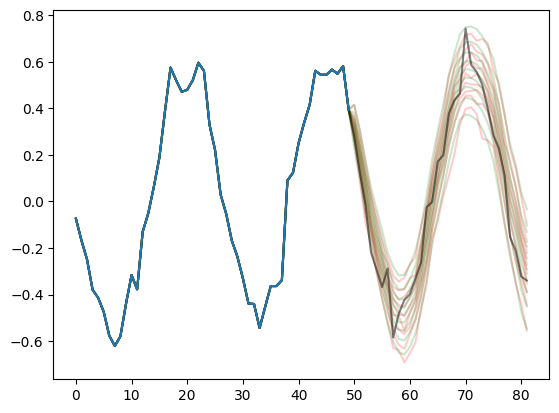

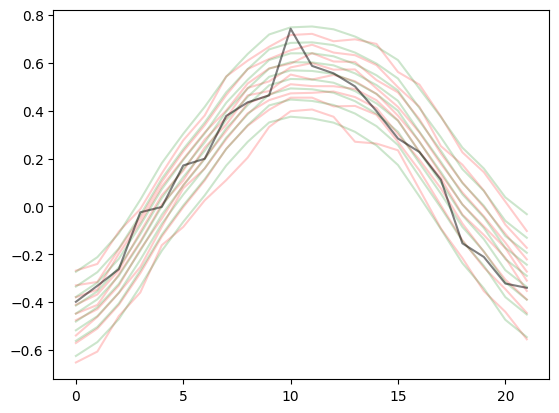

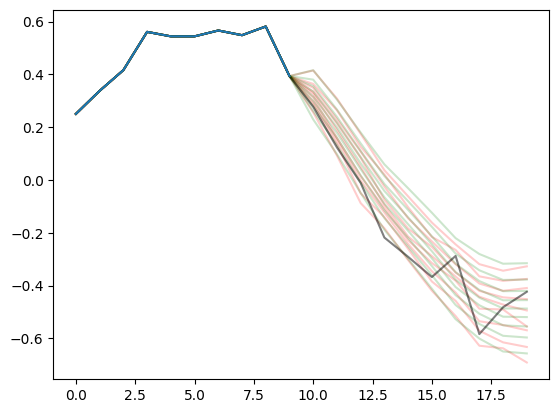

In [24]:
I = 12# index of series

plt.plot(np.quantile(Y[I], np.linspace(0.1, 0.9, 9), axis=0).T, color="red", alpha=0.2)
plt.plot(Ymt[I], color="green", alpha=0.2)
plt.plot(X_full[I].T, alpha=0.5, color="black")
plt.plot(X_full[I,:C].T)
plt.show()

plt.plot(
    np.quantile(Y[I], np.linspace(0.1, 0.9, 9), axis=0)[:, C - 50 :].T,
    color="red",
    alpha=0.2,
)
plt.plot(Ymt[I, C - 50 :], color="green", alpha=0.2)
plt.plot(X_full[I, C - 50 :].T, alpha=0.5, color="black")
plt.plot(X_full[I, C - 50 : C].T)
plt.show()

plt.plot(
    np.quantile(Y[I], np.linspace(0.1, 0.9, 9), axis=0)[:, C + 10 :].T,
    color="red",
    alpha=0.2,
)
plt.plot(Ymt[I, C + 10 :], color="green", alpha=0.2)
plt.plot(X_full[I, C + 10 :].T, alpha=0.5, color="black")
plt.plot(X_full[I, C + 10 : C].T)
plt.show()

plt.plot(
    np.quantile(Y[I], np.linspace(0.1, 0.9, 9), axis=0)[:, C - 10 : C + 10].T,
    color="red",
    alpha=0.2,
)
plt.plot(Ymt[I, C - 10 : C + 10], color="green", alpha=0.2)
plt.plot(X_full[I, C - 10 : C + 10].T, alpha=0.5, color="black")
plt.plot(X_full[I, C - 10 : C].T)
plt.show()

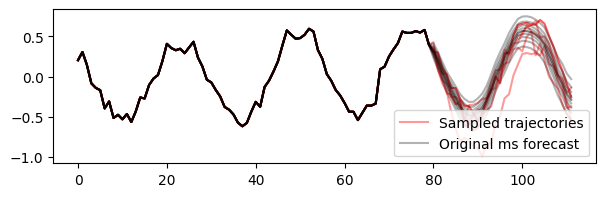

In [25]:
plt.figure(figsize=(7,2))
plt.plot(Y[I, :, C - 80 :][:5].T, alpha=0.4, color="red")
plt.plot(
    Y[I, :, C - 80 :][0].T, alpha=0.4, color="red", label="Sampled trajectories"
)
plt.plot(Ymt[I, C - 80 :], color="black", alpha=0.3)
plt.plot(Ymt[I, C - 80 :,4], color="black", alpha=0.3,label='Original ms forecast')
plt.legend()
plt.show()

## Working with all trajectories quantiles

#### Evolution of forecast for a given horizon as trajectories unfold

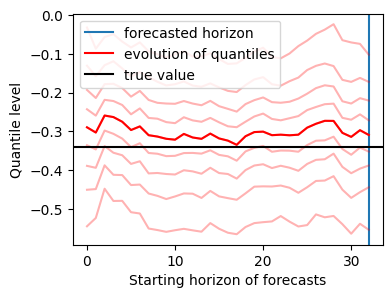

In [51]:
H = P - 1
plt.figure(figsize=(4, 3))
plt.axvline(H + 1, label="forecasted horizon")
plt.plot(
    np.quantile(
        np.array(full_ymt)[:, I, :, H, :].reshape(P+1, -1), np.linspace(0.1, 0.9, 9), axis=1
    )[4],
    color="red",
    label="evolution of quantiles",
)
plt.plot(
    np.quantile(
        np.array(full_ymt)[:, I, :, H, :].reshape(P+1, -1), np.linspace(0.1, 0.9, 9), axis=1
    ).T,
    color="red",
    alpha=0.3,
)


plt.axhline(X_full[I, C + H], color="black", label="true value")
plt.xlabel("Starting horizon of forecasts")
plt.ylabel("Quantile level")
plt.legend()
plt.show()

#### Taking quantiles of firsts 3 trajectories steps

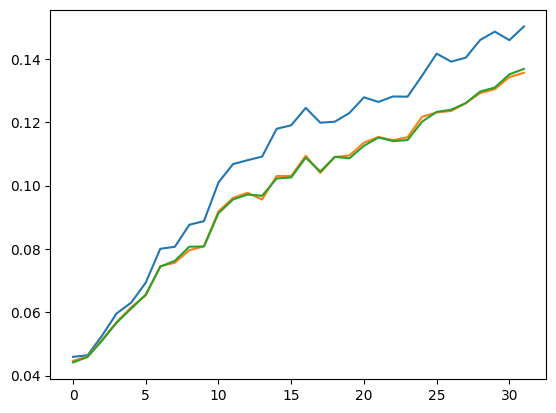

In [50]:
plt.plot(np.mean(np.abs(X_full - np.median(Y, axis=1))[:, C:], axis=0))
plt.plot(
    np.mean(
        np.abs(
            X_full[:, C:]
            - np.quantile(
                np.array(full_ymt)[np.arange(33) < 3]
                .swapaxes(0, 1)
                .swapaxes(1, 3)
                .reshape(len(X_full), P, -1),
                np.linspace(0.1, 0.9, 9),
                axis=2,
            )[4]
        ),
        axis=0,
    )
)
plt.plot(np.mean(np.abs(X_full - Ymt[:, :, 4])[:, C:], axis=0))

#### For a given horizon, taking quantiles from various mix of trajectory steps

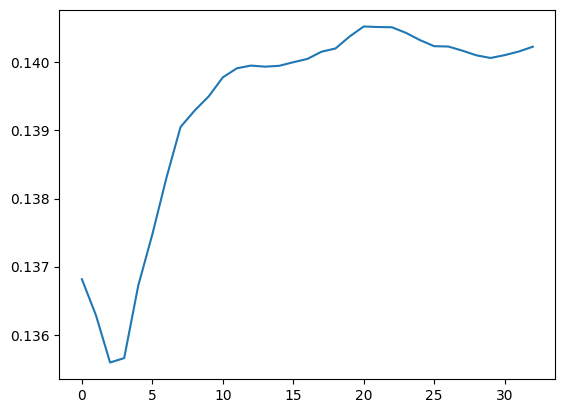

In [46]:
H = (P - 1)

res = []

for k in range(1, P + 2):
    res.append(np.mean(np.abs(np.quantile(
        np.array(full_ymt)[:, :, :, H, :]
        .reshape(P + 1, len(X_full), -1)[: k]
        .swapaxes(0, 1)
        .reshape(len(X_full), -1),
        np.linspace(0.1, 0.9, 9),
        axis=1,
    )[4] - X_full[:, C + H])))

plt.plot(res)
plt.show()